In [15]:
# Please run all the cells sequentially
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

from sklearn import metrics
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score ,roc_auc_score#,plot_confusion_matrix
from sklearn.metrics import recall_score,precision_score, f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,KFold, StratifiedKFold 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC 
import warnings
warnings.simplefilter("ignore")




## Q1 - Load


In [16]:
# Loading the data to a pandas dataframe. Code and data to be kept in the same folder
df = pd.read_json('transactions.txt',lines=True)
df.head(10)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.00,,,,False,,,False,False
1,737265056,737265056,5000,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.00,,,,True,,,False,False
2,737265056,737265056,5000,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
3,737265056,737265056,5000,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
4,830329091,830329091,5000,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.00,,,,True,,,False,False
5,830329091,830329091,5000,5000.00,2016-04-19T16:24:27,30.76,In-N-Out #422833,US,US,02,...,,0.00,,,,True,,,False,False
6,830329091,830329091,5000,5000.00,2016-05-21T14:50:35,57.28,Krispy Kreme #685312,US,US,02,...,,0.00,,,,True,,,False,False
7,830329091,830329091,5000,5000.00,2016-06-03T00:31:21,9.37,Shake Shack #968081,US,US,05,...,,0.00,,,,True,,,False,False
8,830329091,830329091,5000,4990.63,2016-06-10T01:21:46,523.67,Burger King #486122,,US,02,...,,9.37,,,,True,,,False,False
9,830329091,830329091,5000,5000.00,2016-07-11T10:47:16,164.37,Five Guys #510989,US,US,05,...,,0.00,,,,True,,,False,False


In [17]:
print('Dataset summary : Number of entries, fields, non_null entries and data type can be found here')
df.info()

Dataset summary : Number of entries, fields, non_null entries and data type can be found here
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  curren

#### Data Cleaning

Since the dataset is imbalanced we would try not to straightaway drop missing values 
otherwise theres a possibility that minority class ends up with low number of samples


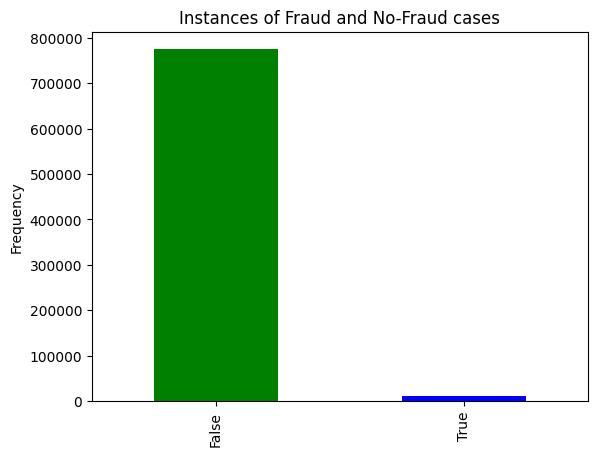

In [18]:
# Check if dataset is balanced or not
df['isFraud'].value_counts().plot(kind='bar',color = {'blue','green'})
plt.title('Instances of Fraud and No-Fraud cases')
plt.ylabel('Frequency')

print('Since the dataset is imbalanced we would try not to straightaway drop missing values \notherwise theres a possibility that minority class ends up with low number of samples')

In [19]:
# Converting 'accountOpenDate', 'currentExpDate', 'dateOfLastAddressChange' & 'transactionDateTime' to Date-Time format
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'])
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

In [20]:
# Removing empty columns those contain blank fields:
print('Dropping emplty columns: merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd')
df = df.drop(['merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd','echoBuffer'],axis=1)

Dropping emplty columns: merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd


In [21]:
#Converting blanks to 'Unknown' in following columns:

# acqCountry
df['acqCountry'].replace({"": "Unknown"},inplace=True)

# transactionType
df['transactionType'].replace({"": "Unknown"},inplace=True)

# merchantCountryCode 
df['merchantCountryCode'].replace({"": "NA"},inplace=True)

#posConditionCode 
df['posConditionCode'].replace({"": "NA"},inplace=True)

#posEntrymode 
df['posEntryMode'].replace({"": "NA"},inplace=True)


#### Brief Analysis of dataset

In [22]:
print('The data consists transaction information for {} different accounts'.format(df['accountNumber'].nunique()))

The data consists transaction information for 5000 different accounts


In [23]:
print('The data consists transaction information for {} different customers'.format(df['customerId'].nunique()))

The data consists transaction information for 5000 different customers


In [24]:
earliest_transaction = min(df['transactionDateTime'])
latest_transaction = max(df['transactionDateTime'])
print('The data contains transaction history from {} to {}'.format(earliest_transaction,latest_transaction))

The data contains transaction history from 2016-01-01 00:01:02 to 2016-12-30 23:59:45


In [25]:
oldest_account = min(df['accountOpenDate'])
latest_account = max(df['accountOpenDate'])
print('Dates for the Oldest and the Newest accounts are {} and {}'.format(oldest_account,latest_account))

Dates for the Oldest and the Newest accounts are 1989-08-22 00:00:00 and 2015-12-31 00:00:00


In [26]:
fraud_per = 100*sum(df['isFraud']==1)/len(df)
print('Percentage of fraudulent transactions is', fraud_per)

Percentage of fraudulent transactions is 1.579041740264992


In [27]:
print('Different transaction types are : ')
df['transactionType'].value_counts()

Different transaction types are : 


PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Unknown                    698
Name: transactionType, dtype: int64

## Q2 - Plot

Maximum transaction value is 2011.54
Minimum transaction value is 0.0
Average transaction value is 136.98579095150708
Median transaction value is 87.9
Most common transaction value is 0.0
Standard deviation in transaction value is 147.7255690194876


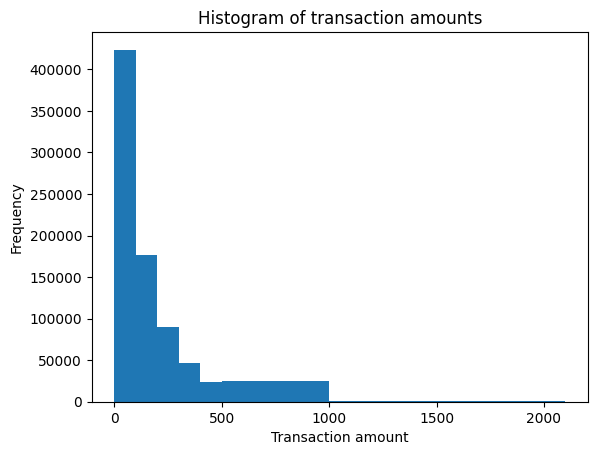

In [28]:
# Plotting histogram of transaction amount
plt.hist(df['transactionAmount'],bins=[0,100,200,300,400,500,1000,2100])
plt.title('Histogram of transaction amounts')
plt.xlabel('Transaction amount')
plt.ylabel('Frequency')


# Descriptive statistics of transaction amount
print('Maximum transaction value is {}'.format(max(df['transactionAmount'])))
print('Minimum transaction value is {}'.format(min(df['transactionAmount'])))
print('Average transaction value is {}'.format((df['transactionAmount'].mean())))
print('Median transaction value is {}'.format((df['transactionAmount'].median())))
print('Most common transaction value is {}'.format((df['transactionAmount'].mode()[0])))
print('Standard deviation in transaction value is {}'.format((df['transactionAmount'].std())))

##### The histogram is right skewed as the median is below the mean value

##### Let's look at different transaction types to gain more insights

In [29]:
# Splitting dataset based on transaction type
df_p = df[df['transactionType']=='PURCHASE']
df_av = df[df['transactionType']=='ADDRESS_VERIFICATION']
df_r = df[df['transactionType']=='REVERSAL']
print('Mean transaction_amount in purchase category is',df_p['transactionAmount'].mean())
print('Mean transaction_amount in address verification category is',df_av['transactionAmount'].mean())
print('Mean transaction_amount in reversal category is',df_r['transactionAmount'].mean())

Mean transaction_amount in purchase category is 140.62169833855123
Mean transaction_amount in address verification category is 0.0
Mean transaction_amount in reversal category is 138.98401714032408


##### It can be seen that mean transaction value under 'Address verification' is 0. Let's only consider 'Purchases'

Maximum transaction value is 2011.54
Minimum transaction value is 0.0
Average transaction value is 140.62169833855123
Median transaction value is 91.8
Most common transaction value is 0.0
Standard deviation in transaction value is 147.94248456728855


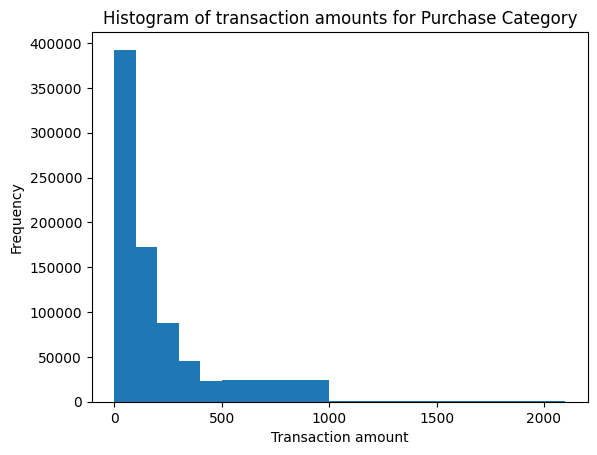

In [30]:
# Plotting histogram of transaction amount for category 'Purchase'
plt.hist(df_p['transactionAmount'],bins=[0,100,200,300,400,500,1000,2100])
plt.title('Histogram of transaction amounts for Purchase Category')
plt.xlabel('Transaction amount')
plt.ylabel('Frequency')

#Descriptive statistics
print('Maximum transaction value is {}'.format(max(df_p['transactionAmount'])))
print('Minimum transaction value is {}'.format(min(df_p['transactionAmount'])))
print('Average transaction value is {}'.format((df_p['transactionAmount'].mean())))
print('Median transaction value is {}'.format((df_p['transactionAmount'].median())))
print('Most common transaction value is {}'.format((df_p['transactionAmount'].mode()[0])))
print('Standard deviation in transaction value is {}'.format(np.std(df_p['transactionAmount'].values)))

##### It can be seen here that most purchases are low in amount ( < USD 50). This is expected as people do not regularly make high value purchases.

##### Some important questions to ask are :

a) When (month of the year or time of the day) do transactions occur more frequently?

b) How does the average amount spent depend on the Credit Limit of Available balance?



c) Which categories (ex: Retail, Healthcare) attract more transactions?

d) What are the characteristics of Heavy spenders or Frequent spenders?

## Q3 Data Wrangling - Duplicate transactions

#### Reverse Transactions

 It can be observed that Reversal type transactions are mentioned under the column 'transactionType'

In [31]:
# Function to generate dataframe of reverse transactions, number of reverse transactions and their total transactional value

def reversal(d_frame):
    d_rev = d_frame[d_frame['transactionType']=='REVERSAL']
    # Number of reverse transactions
    n_rev = len(d_rev)
    # Total transaction amount of reverse transactions
    tot_rev_amt = sum(d_rev['transactionAmount'])
    return d_rev,n_rev,tot_rev_amt

In [32]:
d_reversal,no,amt = reversal(df)
print('Dataframe d_reversal contains information of reverse transactions')
print('Number of reverse transaction are',no)
print('Total transaction value of reverse transactions is',amt)

Dataframe d_reversal contains information of reverse transactions
Number of reverse transaction are 20303
Total transaction value of reverse transactions is 2821792.4999999753


#### Multi-swipe transactions

Two transactions are considered multiswipe transactions, if their Account Numbers, Credit card numbers, Transaction values and Merchant names match exactly and the time difference between the two transactions is small i.e. less than 180 seconds  

 A Reverse transaction can also satisfy the above conditions hence it needs to be filtered out when identifying Multi-swipe transactions

In [33]:
def multiswipe(data):
    
    d_frame = data.copy()
    
    # Creating new upward shifted columns
    d_frame['accno_shift'] = d_frame['accountNumber'].shift(-1)
    d_frame['card_4D_shift'] = d_frame['cardLast4Digits'].shift(-1)
    d_frame['merchant_shift']= d_frame['merchantName'].shift(-1)
    d_frame['trans_shift'] = d_frame['transactionAmount'].shift(-1)
    d_frame['transtime_shift'] = d_frame['transactionDateTime'].shift(-1)
    d_frame['transtype_shift'] = d_frame['transactionType'].shift(-1)
    d_frame['Time_diff'] = d_frame['transtime_shift'] - d_frame['transactionDateTime']
    
    # Specifying conditions
    filter1 = d_frame['transactionAmount']==d_frame['trans_shift']
    filter2 = d_frame['transactionType']==d_frame['transtype_shift']
    filter3 = d_frame['Time_diff'].dt.total_seconds() < 180
    filter4 = d_frame['merchantName'] == d_frame['merchant_shift']
    filter5 = d_frame['cardLast4Digits'] == d_frame['card_4D_shift']
    d_frame['Multi'] = filter1 & filter2 & filter3 & filter4 & filter5
    multiswipeindex = d_frame[d_frame['Multi']==True].index
    
    d_multi = data.ix[multiswipeindex]
    n_multi = len(d_multi)
    tot_amt_multi = sum(d_multi['transactionAmount'])
    
    return d_multi,n_multi,tot_amt_multi

In [34]:
df_multiswipe,n_multi_swipe,amt_multiswipe = multiswipe(df)
print('df_multiswipe consists of multi_swipe transactions')
print('Number of multi-swipe transactions are',n_multi_swipe)
print('Total value of multiswipe transactions is',amt_multiswipe)

AttributeError: 'DataFrame' object has no attribute 'ix'

In [ ]:
df_multiswipe.head(5)

## Q4 - Modelling

#### Adding New Features

In [ ]:
df3 = df.copy()

# Creating new features which could be helpful in predicting fraud transactions

# Calculating age of account by subtracting accountOpenDate from transaction_Date
df3['account_age'] = (df3['transactionDateTime']-df3['accountOpenDate']).dt.days

# Calculating remaining account age by subtracting transaction_Date from expiry date 
df3['account_rem'] = (df3['currentExpDate'] - df3['transactionDateTime']).dt.days

# Subtracting date of last address change from transaction date time
df3['address_change'] = (df3['transactionDateTime']-df3['dateOfLastAddressChange']).dt.days

# Adding a boolean feature that specifies if enetered CVV is same as Card CVV
df3['CVV_match'] = df3['cardCVV'] == df['enteredCVV']

df3.info()

#### Exploratory data analysis

In [ ]:
#Checking the effect of account_age on whether fraud or not
df3.groupby('isFraud').account_age.mean().plot(kind='bar',color=('green','red'))
plt.ylabel('Age of account')
plt.title('Account age vs Fraud status')
plt.show()
print('Fraud transactions class has lower account age')

In [ ]:
#Checking the effect of Time since address Change on whether fraud or not
df3.groupby('isFraud').address_change.mean().plot(kind='bar',color=('green','red'))
plt.ylabel('Time since address Change')
plt.title('Time since Address Change vs Fraud status')
plt.show()
print('Fraud transactions class has a lower average time since last address change')

In [ ]:
df3.groupby('isFraud').transactionAmount.mean().plot(kind='bar',color=('green','red'))
plt.ylabel('Transaction amount')
plt.title('Transaction amount vs Fraud status')
plt.show()
print('Fraud transactions class has a higher average transaction amount')

In [ ]:
df3.groupby('isFraud').expirationDateKeyInMatch.mean().plot(kind='bar',color=('green','red'))
plt.ylabel('Expiration Key Match')
plt.title('Expiration key match vs Fraud status')
plt.show()
print('Fraud transactions class has lower instances of expiration key matches')

In [ ]:
df3.groupby('isFraud').cardPresent.mean().plot(kind='bar',color=('green','red'))
plt.ylabel('Card presence')
plt.title('Card presence vs Fraud status')
plt.show()
print('Fraud transactions class has lower instances when card was present')

In [ ]:
df3.groupby('posEntryMode').isFraud.mean().plot(kind='bar')
plt.ylabel('Average fraud cases')
plt.title('POS entry mode vs Fraud status')
plt.show()
print('Samples with Unknown POS entry mode have higher instances of Fraud')

In [ ]:
df3.groupby('posConditionCode').isFraud.mean().plot(kind='bar')
plt.ylabel('Average fraud cases')
plt.title('POS condition code vs Fraud status')
plt.show()
print('Samples with Unknown POS Condition Code have higher instances of Fraud')

In [ ]:
df3.groupby('merchantCountryCode').isFraud.mean().plot(kind='bar')
plt.ylabel('Average fraud cases')
plt.title('Merchant country code vs Fraud status')
plt.show()
print('Samples with Unknown Merchant country code have higher instances of Fraud')

#### Feature Correlation Matrix

In [ ]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df3)

##### 'creditLimit' and 'avaialbeMoney' are correlated features and hence we would keep only one of them in our model

##### 'creditLimit and 'currentBalance' are correlated features and hence we would keep only one of them in our model

##### Similarly, 'Entered CVV' and 'Card CVV' are correlated and 'CustomerId' and 'AccountNumber' are correlated and we would keep one in each pair

In [ ]:
# Specifying input features and target variable
X = df3[['accountNumber','account_age','address_change','currentBalance','availableMoney','CVV_match','transactionAmount','expirationDateKeyInMatch','cardPresent','posEntryMode','posConditionCode','merchantCountryCode','transactionType']]
Y = df3['isFraud']
X.info()

#### Training on Original Imbalanced Dataset

In [ ]:
# Creating Training (80%) and Test sets(20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
# Creating a preprocessing pipeline


# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


# Create pipeline for text features
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])


# Select numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object','bool']).columns


# Apply transformers to relevant columns
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

In [ ]:
# Creating final pipeline with preprocessor and estimator

# Fitting Logistic regression
lr = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', LogisticRegression(max_iter=400))])
lr.fit(X_train, Y_train)

In [ ]:
# Evaluating model performance on test data
y_pred = lr.predict(X_test)
print('Accuracy is:',metrics.accuracy_score(y_pred, Y_test))
print('Although the accuracy is high, this is not the correct metric to gauge model performance in imbalanced datasets')

In [ ]:
#Printing Confusion Matrix
results = confusion_matrix(Y_test.values, y_pred)
tn, fp, fn, tp = results.ravel()
disp = plot_confusion_matrix(lr, X_test, Y_test,cmap=plt.cm.Blues)
print('Confusion Matrix:')
plt.show()

ROC_lr = roc_auc_score(Y_test.values, y_pred)
rs_lr = recall_score(Y_test, y_pred)
ps_lr = precision_score(Y_test, y_pred)
f1_lr = f1_score(Y_test, y_pred)

print('ROC_AUC   :' , ROC_lr)
print('Recall    :' , rs_lr)
print('Precision :' , ps_lr)
print('F1-Score  :' , f1_lr)

print('It can be observed that Recall is 0')
print('This means prediction is biased towards majority classes i.e. predicting almost everything as False')

#### Weighted Logistic Regression for Imbalanced Datasets


Let's try weighted Logistic Regression

Changing the weight configuration in the Loss Function would penalize the model less for errors made on majority class (No-Fraud) samples and penalize the model more for errors made on minority class (Fraud) samples

This can be done by specifying 'class_weight' parameter in scikitlearn LogisticRegression estimator

In [ ]:
# Creating weighted losgistic regression pipeline
lr_w = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', LogisticRegression(max_iter=400,class_weight = {0: 1, 1: 80}))])

lr_w.fit(X_train,Y_train)


# Optimal class weights were found by 5-fold Cross Validation Grid search, running the code below


# Specifying class weights to be tried out
#weights = [{0:1,1:50}, {0:1,1:70}, {0:1,1:80},{0:1,1:85}, {0:1,1:90}]
#param_grid = {'classifier__class_weight' : weights}

# Using 5 fold Cross validation based Grid search to look for optimal class weights - Criterie = ROC_AUC
#kfolds= KFold(n_splits=5)

# Specifying selection criteria as 'ROC_AUC'
#CV=GridSearchCV(lr_w,param_grid,cv=kfolds,scoring='roc_auc')   
#CV.fit(X_train, Y_train)
#print(CV.best_params_)
#print(CV.best_score_)

In [ ]:
# Evaluating performance on test set
y_pred = lr.predict(X_test)
print('Accuracy is:',metrics.accuracy_score(y_pred, Y_test))
print('Although the accuracy is high, this is not the correct metric to gauge model performance in imbalanced datasets')

#Printing Confusion Matrix
results = confusion_matrix(Y_val.values, y_pred)
tn, fp, fn, tp = results.ravel()
disp = plot_confusion_matrix(lr_w, X_val, Y_val,cmap=plt.cm.Blues)
print('Confusion Matrix:')
plt.show()

print (classification_report(Y_val.values, y_pred))
print('Accuracy got decreased but recall got increased to ~75')
print('Gives less biased predictions than standard logistic regression')

#### Trying Random Undersampling


In [ ]:
# Creating undersampled dataset
sampling_strategy = 0.8
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_rus, Y_rus = rus.fit_resample(X,Y)
print('After random undersampling, the distribution of classes is : ')
Y_rus.value_counts().plot(kind='bar',color = {'blue','green'})
plt.title('Instances of Fraud and No-Fraud cases')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Creating Training (80%), Validation(10%) and Test sets(10%)
X_train, X_test, Y_train, Y_test = train_test_split(X_rus, Y_rus, test_size=0.2)

In [ ]:
# Fitting Logistic Regression
lr_us = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', LogisticRegression(max_iter=400,class_weight={0:1,1:1.5}))])

#Optimal class weights were found by 5-fold Cross Validation Grid search

lr_us.fit(X_train,Y_train)

In [ ]:
# Evaluating performance on test set
y_pred = lr_us.predict(X_test)

#Printing Confusion Matrix
results = confusion_matrix(Y_test.values, y_pred)
tn, fp, fn, tp = results.ravel()
disp = plot_confusion_matrix(lr_us, X_test, Y_test,cmap=plt.cm.Blues)
print('Confusion Matrix:')
plt.show()

ROC_lr_us = round(roc_auc_score(Y_test.values, y_pred),2)
rs_lr_us = round(recall_score(Y_test, y_pred),2)
ps_lr_us = round(precision_score(Y_test, y_pred),2)
f1_lr_us = round(f1_score(Y_test, y_pred),2)

print('ROC_AUC   :' , ROC_lr_us)
print('Recall    :' , rs_lr_us)
print('Precision :' , ps_lr_us)
print('F1-Score  :' , f1_lr_us)

In [ ]:
# Lets try k nearest neighbors with the undersampled dataset
knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier(n_neighbors=5))])

# nearest neighbors = 5 found by 5 fold Grid search

knn.fit(X_train,Y_train)

In [ ]:
# Evaluating performance on test set
y_pred = knn.predict(X_test)

#Printing Confusion Matrix
results = confusion_matrix(Y_test.values, y_pred)
tn, fp, fn, tp = results.ravel()
disp = plot_confusion_matrix(knn, X_test, Y_test,cmap=plt.cm.Blues)
print('Confusion Matrix:')
plt.show()

ROC_knn = round(roc_auc_score(Y_test.values, y_pred),2)
rs_knn = round(recall_score(Y_test, y_pred),2)
ps_knn = round(precision_score(Y_test, y_pred),2)
f1_knn = round(f1_score(Y_test, y_pred),2)

print('ROC_AUC   :' , ROC_knn)
print('Recall    :' , rs_knn)
print('Precision :' , ps_knn)
print('F1-Score  :' , f1_knn)

In [ ]:
# Lets try SVM
from sklearn import svm
svm = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', svm.SVC(kernel="rbf",C = 10, gamma = 0.1))])

# Optimal parameters C = 10, gamma = 0.1 found by Grid Search 5 fold CV
svm.fit(X_train,Y_train)  

In [ ]:
# Evaluating performance on test set
y_pred = svm.predict(X_test)

#Printing Confusion Matrix
results = confusion_matrix(Y_test.values, y_pred)
tn, fp, fn, tp = results.ravel()
disp = plot_confusion_matrix(svm, X_test, Y_test,cmap=plt.cm.Blues)
print('Confusion Matrix:')
plt.show()

ROC_svm = round(roc_auc_score(Y_test.values, y_pred),2)
rs_svm = round(recall_score(Y_test, y_pred),2)
ps_svm = round(precision_score(Y_test, y_pred),2)
f1_svm = round(f1_score(Y_test, y_pred),2)

print('ROC_AUC   :' , ROC_svm)
print('Recall    :' , rs_svm)
print('Precision :' , ps_svm)
print('F1-Score  :' , f1_svm)

In [ ]:
# XG-BOOST
xg = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', XGBClassifier(max_depth=5,n_stimators=500))])

#Optimal parameters max_depth=5,n_stimators=500 found by 5-fold cv using Grid search  
xg.fit(X_train,Y_train)

In [ ]:
# Evaluating performance on test set
y_pred = xg.predict(X_test)

#Printing Confusion Matrix
results = confusion_matrix(Y_test.values, y_pred)
tn, fp, fn, tp = results.ravel()
disp = plot_confusion_matrix(xg, X_test, Y_test,cmap=plt.cm.Blues)
print('Confusion Matrix:')
plt.show()

ROC_xg = round(roc_auc_score(Y_test.values, y_pred),2)
rs_xg = round(recall_score(Y_test, y_pred),2)
ps_xg = round(precision_score(Y_test, y_pred),2)
f1_xg = round(f1_score(Y_test, y_pred),2)

print('ROC_AUC   :' , ROC_xg)
print('Recall    :' , rs_xg)
print('Precision :' , ps_xg)
print('F1-Score  :' , f1_xg)

In [ ]:
#Random Forrest Classifier

rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier(max_depth=10,n_estimators=200))])

#Optimal parameters max_depth=10,n_stimators=200 found by 5-fold cv using Grid search  
rf.fit(X_train,Y_train)

In [ ]:
# Evaluating performance on test set
y_pred = rf.predict(X_test)

#Printing Confusion Matrix
results = confusion_matrix(Y_test.values, y_pred)
tn, fp, fn, tp = results.ravel()
disp = plot_confusion_matrix(rf, X_test, Y_test,cmap=plt.cm.Blues)
print('Confusion Matrix:')
plt.show()

ROC_rf = round(roc_auc_score(Y_test.values, y_pred),2)
rs_rf = round(recall_score(Y_test, y_pred),2)
ps_rf = round(precision_score(Y_test, y_pred),2)
f1_rf = round(f1_score(Y_test, y_pred),2)

print('ROC_AUC   :' , ROC_rf)
print('Recall    :' , rs_rf)
print('Precision :' , ps_rf)
print('F1-Score  :' , f1_rf)

In [ ]:
# Checking results of undersampled data models
print('Logistic Regression - ROC_AUC : {}, Recall : {}, Precision : {}, f1_score : {}'.format(ROC_lr_us,rs_lr_us,ps_lr_us,f1_lr_us))
print('SVM                 - ROC_AUC - {}, Recall : {}, Precision : {}, f1_score : {}'. format(ROC_svm,rs_svm,ps_svm,f1_svm))
print('knn                 - ROC_AUC - {}, Recall : {}, Precision : {}, f1_score : {}'. format(ROC_knn,rs_knn,ps_knn,f1_knn))
print('XGboost             - ROC_AUC - {}, Recall : {}, Precision : {}, f1_score : {}'. format(ROC_xg,rs_xg,ps_xg,f1_xg))
print('Random Forrest      - ROC_AUC : {}, Recall : {}, Precision : {}, f1_score : {}'. format(ROC_rf,rs_rf,ps_rf,f1_rf))

##### f1_score is a good metric which balances both Recall and Precision. Hence we choose weighted Logistic Regression model which has the highest f1_score. Notice that it's Recall is also the highest, which is desirable in our case

### Future Work

##### A humble attempt at implementing SMOTE (Synthetic Minority Oversampling TEchnique) is made in current work. But this technique would be explored more comprehensively in future

In [ ]:
sm = SMOTENC(categorical_features=[5,7,8,9,10,11,12])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_ov, Y_ov = sm.fit_resample(X_train,Y_train)

In [ ]:
print('After Oversampling, the distribution of classes is : ')
Y_ov.value_counts().plot(kind='bar',color = {'blue','green'})
plt.title('Instances of Fraud and No-Fraud cases')
plt.ylabel('Frequency')
plt.show()

In [ ]:
lr_ov = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', LogisticRegression(solver='lbfgs',max_iter=400))])
lr_ov.fit(X_ov,Y_ov)

In [ ]:
# Evaluating performance on test set
y_pred = lr_ov.predict(X_test)

#Printing Confusion Matrix
results = confusion_matrix(Y_test.values, y_pred)
tn, fp, fn, tp = results.ravel()
disp = plot_confusion_matrix(lr_ov, X_test, Y_test,cmap=plt.cm.Blues)
print('Confusion Matrix:')
plt.show()

ROC_lr_ov = round(roc_auc_score(Y_test.values, y_pred),2)
rs_lr_ov = round(recall_score(Y_test, y_pred),2)
ps_lr_ov = round(precision_score(Y_test, y_pred),2)
f1_lr_ov = round(f1_score(Y_test, y_pred),2)

print('ROC_AUC   :' , ROC_lr_ov)
print('Recall    :' , rs_lr_ov)
print('Precision :' , ps_lr_ov)
print('F1-Score  :' , f1_lr_ov)

print('Gives better result than Standard Logistic regression on Imbalanced dataset')
print('Oversampling reduces bias in prediction')